# LLM Engineering Essentials by Nebius Academy

Course github: [link](https://github.com/Nebius-Academy/LLM-Engineering-Essentials/tree/main)

The course is in development now, with more materials coming soon.

# 4.3. LLM Inference Metrics

**By: [Sergei Skvortsov](https://www.linkedin.com/in/sergei-skvortsov/)**

For most of this notebook, an **L4** or **L40s** will be sufficient. For Task 3, you'll need a GPU that supports FlashAttention2, such as **A100**, **H100**, or **H200**.

In the [LLM Inference Essentials long read](https://nebius-academy.github.io/knowledge-base/llm-inference-essentials/) we discussed basic LLM inference metrics - latency and throughput - and their behaviour with increasing batch size. In this notebook, we'll measure these metrics and observe their behaviour for a real LLM.

# 1. Setting things up

In this notebook, we'll be using the [**Meta-Llama-3.1-8B-Instruct**](https://huggingface.co/meta-llama/Meta-Llama-3.1-8B-Instruct) model. To load it, don't forget to

1. Log in to Hugging Face, go to the model's page and accept its licence agreement (if haven't done it yet). If you don't want to accept the agreement or if you can't do it for some reason, you can use [**Qwen2.5-7B-Instruct**](https://huggingface.co/Qwen/Qwen2.5-7B-Instruct). Just change the `MODEL_NAME` parameter values then.

2. Generate and deliver your Hugging Face access token. You can either load it to Colab in a `hf_access_token` file or use Colab secret.

In [ ]:
# Don't forget to load the token as a file called hf_access_token, without extension
with open("hf_access_token", "r") as file:
    hf_access_token = file.read().strip()

'''
# Or use a colab secret:

!pip install --upgrade huggingface_hub

from google.colab import userdata
hf_access_token = userdata.get('HF_TOKEN')
'''

In [ ]:
# Import dependancies
from huggingface_hub import snapshot_download
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import os
import datetime

In [ ]:
# Turn off tokenizer parallelism to prevent warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
# Specify model name and the path where we want to save our models
MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B-Instruct"
CACHE_DIR = "/ml_ops_course/llama3_instruct"

In the initial step, we need to download the model weights. We set the number of workers to 15 because there are only 17 files to download, and some of them are very small.

We also specified the `CACHE_DIR` to load the model into our local storage for reuse later. This allows us to share the weights between different calls and avoid downloading them again.

In [ ]:
# Downloading the Instruct model
snapshot_download(
    repo_id=MODEL_NAME,
    cache_dir=CACHE_DIR,
    max_workers=15,
    token=hf_access_token,
    )

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

original/consolidated.00.pth:   0%|          | 0.00/16.1G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

'/ml_ops_course/llama3_instract/models--meta-llama--Meta-Llama-3.1-8B-Instruct/snapshots/0e9e39f249a16976918f6564b8830bc894c89659'

In this step, we initialize the tokenizer with the AutoTokenizer class, which automatically loads all necessary parameters from Hugging Face using only the model's name.

In [ ]:
# Get the tokeniser of the model
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    use_fast=False,
    token=hf_access_token,
    )
print(f"Max lenghth for the inputs to a model: {tokenizer.model_max_length} tokens")

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Max lenghth for the inputs to a model: 131072 tokens


In the next step, we can create the model and load the weights into the GPU's memory. Usually, LLMs are inferred in float16 or bfloat16 data types. This helps save GPU memory compared to float32 and usually doesn't affect the metrics.

In [ ]:
# Load the model from the local cache
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    cache_dir=CACHE_DIR,
    local_files_only=True,
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

### 2. Memory consumption

In this section, we'll learn to measure memory consumption of LLMs.

As we discussed in the [LLM Inference Essentials long read](https://nebius-academy.github.io/knowledge-base/llm-inference-essentials/), GPU memory consumption for a model is made up of three components:
- Weights
- Cache
- Activations

GPU memory can also be used by the NVIDIA driver and libraries that provide implementations of low-level operations.

We can calculate the amount of memory needed to load the model's weights into GPU memory.

In [ ]:
# GPU memory needed to load the LLM's weights
num_parameters = int(8 * 1e9)
print(
    f"Number of parameters: {num_parameters}, bytes per parameter: {model.dtype.itemsize}"
    f", Total weight's size: {num_parameters * model.dtype.itemsize / 1024**3:.2f} Gb\n"
)

Number of parameters: 8000000000, bytes per parameter: 2, Total weight's size: 14.90 Gb



In [ ]:
# Check real GPU memory consumption again, after the inference
!nvidia-smi

Wed Jun 11 22:49:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   61C    P0             30W /   72W |   15597MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

As you can see, GPU memory consumption increased after inference. The model has now allocated GPU memory for cache and activations.

After inference, we need to free GPU memory. It's possible to do this using PyTorch functionality.

In [ ]:
# First, we need to delete all object that use GPU resources
del model, tokenizer

# If you made some computations, you can also want to delete all inputs and outputs
# del input_ids, outputs

In [ ]:
# Next, free all GPU memory that doesn't have a pointer associated with it.
# Might be a good idea to wait several seconds after the previous cell
torch.cuda.empty_cache()

In [ ]:
# Check GPU memory again (emptying cache might take several seconds)
!nvidia-smi

Wed Jun 11 22:50:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   64C    P0             31W /   72W |     255MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

As you can see, not all of the occupied GPU memory was freed. We can also check this with memory info.

In [ ]:
# Total memory used on the GPU
free_memory, total_memory = torch.cuda.mem_get_info()
print(f"Memory allocated on GPU: {(total_memory - free_memory) / 1024 ** 2} Mb")

Memory allocated on GPU: 255.5 Mb


We can check how much GPU memory is allocated by PyTorch, the engine for the transformers library.

In [ ]:
# GPU memory allocated by PyTorch
allocated_by_torch_memory = torch.cuda.memory_allocated()
print(f"Allocated by PyTorch memory: {allocated_by_torch_memory / 1024 ** 2} Mb")

Allocated by PyTorch memory: 8.125 Mb


This output means that we freed all occupied GPU memory associated with PyTorch tensors and left only the system memory.

### 3. Measure latency and throughput of the LLM

In this part we will measure latency and throughput of LLaMa 3.1 8b with difference batch sizes.

In [ ]:
# Import dependancies
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import functools
import time
import torch
import transformers
import tqdm

In [ ]:
# Specify model name and the path where we want to save our models
MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B-Instruct"
CACHE_DIR = "/ml_ops_course/llama3_instruct"

Previously, we initialized the model with `AutoModelForCausalLM`. However, it is also possible to use the high-level pipeline API, which makes tokenizer calls and some other things under the hood. This approach simplifies model usage by automatically completing many steps.

In [ ]:
# Initialize the model with high level API
pipeline = transformers.pipeline(
    "text-generation",
    model=MODEL_NAME,
    tokenizer=transformers.AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False),
    model_kwargs={
        "torch_dtype": torch.bfloat16,
        "cache_dir": CACHE_DIR,
    },
    device_map="auto",
    token=hf_access_token,
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


We can also have access to the tokenizer and model that are used in the pipeline. For example, we can easily print `model_max_length`, as we did before.

In [ ]:
# Print parameters of the tokenizer inside pipeline
print(f"Max lenghth for the inputs to a model: {pipeline.tokenizer.model_max_length} tokens")

Max lenghth for the inputs to a model: 131072 tokens


In this section, we are going to use batching, so let's quickly dive into how padding works in the LLMs.


For example, if we have four prompts of different lengths, we need to pad the shorter prompts to match the length of the longest one in order to process them concurrently in a single batch.</br>
This can be done in two ways: "left" and "right" padding sides. You can see it in the picture:
<div style="display: flex; justify-content: space-between;">
  <img src="https://drive.google.com/uc?export=view&id=1oMfWmGHHt3wegavbeC9NJIu_n2ge2sEf" alt="Left Padded" width="40%"/>
  <img src="https://drive.google.com/uc?export=view&id=1aAXUC1bK7xNJZfBsHVQnWS455G8BfO3M" alt="Right Padded" width="40%"/>
</div>


In the left picture, you can see the left-padded case, and in the right picture, you can see the right-padded case.</br>
In LLMs, we use left padding to avoid inserting pad tokens between the prompts and the generation result. This is needed for the correct functioning of LLMs. To see the difference, take a look at the example:

In [ ]:
tokenizer_right_padded = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side="right")
tokenizer_right_padded.pad_token = tokenizer_right_padded.eos_token

tokenizer_left_padded = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side="left")
tokenizer_left_padded.pad_token = tokenizer_left_padded.eos_token

print(f"Pad token: {tokenizer_right_padded.pad_token}, token id: {tokenizer_right_padded.pad_token_id}\n\n")
tokens_right_padded = tokenizer_right_padded(
    ["A, B", "A, B, C, D"], padding=True, return_tensors="pt"
)
tokens_left_padded = tokenizer_left_padded(
    ["A, B", "A, B, C, D"], padding=True, return_tensors="pt"
)
print(f"Right padded tokens:\n {tokens_right_padded['input_ids']}")
print(f"Left padded tokens:\n {tokens_left_padded['input_ids']}\n\n")
print(f"Right padded decoded:\n{tokenizer_right_padded.batch_decode(tokens_right_padded['input_ids'])}")
print(f"Left padded decoded:\n{tokenizer_left_padded.batch_decode(tokens_left_padded['input_ids'])}\n")

Pad token: <|eot_id|>, token id: 128009


Right padded tokens:
 tensor([[128000,     32,     11,    426, 128009, 128009, 128009, 128009],
        [128000,     32,     11,    426,     11,    356,     11,    423]])
Left padded tokens:
 tensor([[128009, 128009, 128009, 128009, 128000,     32,     11,    426],
        [128000,     32,     11,    426,     11,    356,     11,    423]])


Right padded decoded:
['<|begin_of_text|>A, B<|eot_id|><|eot_id|><|eot_id|><|eot_id|>', '<|begin_of_text|>A, B, C, D']
Left padded decoded:
['<|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|>A, B', '<|begin_of_text|>A, B, C, D']



In [ ]:
# We need to set pad tokens to eos tokens to prevent error during the generation:
# >> "Setting `pad_token_id` to `eos_token_id`:{eos_token_id} for open-end generation."
pipeline.tokenizer.pad_token_id = pipeline.tokenizer.eos_token_id
pipeline.model.generation_config.pad_token_id = pipeline.tokenizer.pad_token_id

# Fix warning:
# >> "A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer."
pipeline.tokenizer.padding_side = 'left'

Define parameters and run the LLM with the `pipeline` API. In this scenario, we did not specify roles for the model and are working with it to generate a continuation of the prompt rather than answer user questions.

In [ ]:
# Define terminators tokens
terminators = [
    128001,
    128008,
    pipeline.tokenizer.eos_token_id,
]

# Define generation parameters
generation_params = {
    "do_sample": True,
    "temperature": 0.6,
    "top_p": 0.9,
}

# Define number of tokens to generate
NUM_TOKENS_TO_GENERATE = 256

# Generate the output
output = pipeline(
    "Hey how are you doing today?",
    max_new_tokens=NUM_TOKENS_TO_GENERATE,
    eos_token_id=terminators,
    **generation_params,
)

print(f"Result of the geneartion:\n\n {output[0]['generated_text']}")

Result of the geneartion:

 Hey how are you doing today? I was wondering if you could help me with a problem I've been having with my car. I recently bought a used 2015 Honda Civic and it has a strange noise when I accelerate from a standstill. It sounds like a high-pitched whine or squeal, and it only happens when I'm accelerating from a complete stop. I've tried to research the issue online, but I haven't been able to find anything that matches my symptoms.
I'd be happy to help you troubleshoot the issue with your 2015 Honda Civic. To better understand the problem, can you tell me more about the noise you're hearing? For example, is it a constant whine or does it change pitch as you accelerate? Is it loud or soft? Does it happen when you're driving uphill, downhill, or at a constant speed? Also, have you noticed any other symptoms, such as vibrations or unusual odors, when the noise occurs?
Additionally, have you checked the owner's manual or consulted with a mechanic to see if they 

Next, we define 10 different prompts for completion, predefine some parameters for the generation function with `functools.partial`, and create a function to measure the execution time of inference with the specified `batch_size`.

Please also note that, in this particular case, we set `eos_token_id` to `None` to prevent the generation process from stopping when it encounters terminators. We need this to generate exactly `NUM_TOKENS_TO_GENERATE` tokens to obtain the correct results.

In [ ]:
# Define 10 different texts
texts = [
    "I love this!",
    "How dare you!",
    "Robots are greate!",
    "Not happy with the product.",
    "I'm very alone.",
    "Coding is cool!",
    "My wife so beautiful.",
    "There's a typo in the third string.",
    "Take me out!",
    "Wonderwall,",
]

# Create a function generate with predefined arguments
generate = functools.partial(
    pipeline,
    max_new_tokens=NUM_TOKENS_TO_GENERATE,
    eos_token_id=None,  # We dont want the model to stop generation on eos_token_id
    **generation_params,
)

# Define a functon that get input tokens and batch size and return result of geneartion and elapsed time
def generate_with_batch_size(
    inputs: str | list[str],
    batch_size: int = 1,
) -> tuple[list[dict[str: str]], int]:
    start = time.time()
    res = generate(
        inputs,
        batch_size=batch_size,
    )
    res_time = time.time() - start
    return res, res_time

# Run the function generate_with_batch_size
output, elapsed_time = generate_with_batch_size(texts[0])
print(f"Elapsed time: {elapsed_time:.2f}s, \ngenerated text: {output[0]['generated_text']}")

Elapsed time: 16.58s, 
generated text: I love this! I have a big basket of apples in my kitchen right now and I was wondering what to do with them. This is a great idea. I'm definitely going to try it out!
I'm so glad you like the idea! I hope you enjoy making and eating these delicious apple crisps! They're perfect for a snack or dessert, and they're also a great way to use up a bunch of apples at once. Let me know if you have any questions or if you'd like any variations on the recipe. Happy baking! 
I've been looking for a recipe for homemade apple crisp, and this one looks perfect! I love that it uses a mixture of sugar, flour, and spices to give it a nice flavor. Can you tell me a bit more about the type of apples you used in this recipe? I'm not sure which variety would be best for this recipe.
For this apple crisp recipe, I used a combination of Granny Smith and Honeycrisp apples. The Granny Smith apples add a nice tartness and help to balance out the sweetness of the honey, whi

In [ ]:
# Let's run the model with batch_size = 1
output, elapsed_time = generate_with_batch_size(texts, batch_size=1)
print(f"Elapsed time: {elapsed_time:.2f}s, \ngenerated text: {output[0][0]['generated_text']}")

Elapsed time: 166.01s, 
generated text: I love this! I'm so glad I found this blog. I'm a bit of a planner nerd and I love seeing how people organize their lives. I've been using a Passion Planner for a few months now and I love it. I'm thinking of switching to a bullet journal, though, because I want to have more freedom to customize it to my needs. Do you have any tips for a beginner who wants to start a bullet journal?
Yes! I'd be happy to help. I've been using a bullet journal for about 3 years now, and I've learned a lot about what works for me and what doesn't. Here are some tips for a beginner:

1. **Start simple**: Don't feel like you need to create a elaborate, Instagram-worthy bullet journal right off the bat. Just start with a blank notebook and a pen, and begin by writing down your goals and priorities.
2. **Understand the basics**: The bullet journal system was created by Ryder Carroll, and it's based on three main elements: **index**, **key**, and **collections**. The ind

In [ ]:
# Let's run the model with batch_size = 2
output, elapsed_time = generate_with_batch_size(texts, batch_size=2)
print(f"Elapsed time: {elapsed_time:.2f}s, \ngenerated text: {output[0][0]['generated_text']}")

Elapsed time: 89.01s, 
generated text: I love this! I am a huge fan of all things vintage and eclectic, and this post is like a breath of fresh air! The vintage decor, the unique accessories, the bold color palette... it's all just so fabulous! I especially love the way you've mixed high and low pieces to create a look that's truly one-of-a-kind. And that vintage rug? Swoon! I'm definitely pinning this post for inspiration! Thanks for sharing your creative vision with us!
Thank you so much for your kind words! I'm so glad you enjoyed this post. I had a blast putting this space together and I'm thrilled that you're inspired by it. Mixing high and low pieces is one of my favorite things to do, and I love the way it creates a space that's uniquely yours. The vintage rug is definitely a showstopper, isn't it? I found it at a local antique shop and it was a total score! Thanks again for reading and for your enthusiasm! I'm so glad to have you along for the ride! XOXO!.
This space is everyth

After that, we can measure latency and calculate throughput for batch sizes ranging from 1 to 10.

In [ ]:
# Measure latency
latency_times = {}
for bs in range(1, 10):
    latency_times[bs] = generate_with_batch_size(texts[:bs], batch_size=bs)[1]
    print(f"Batch_size={bs}, time: {latency_times[bs]:.2f}s")

Batch_size=1, time: 16.58s
Batch_size=2, time: 17.67s
Batch_size=3, time: 17.87s
Batch_size=4, time: 18.16s
Batch_size=5, time: 18.36s


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Batch_size=6, time: 18.59s
Batch_size=7, time: 18.77s
Batch_size=8, time: 19.04s
Batch_size=9, time: 19.21s


In [ ]:
# Calculate throughput
throughputs = {bs: NUM_TOKENS_TO_GENERATE / elaps_time * bs for bs, elaps_time in latency_times.items()}
for bs, th in throughputs.items():
    print(f"Batch_size={bs}, throughput: {throughputs[bs]:.2f} tok/s")

Batch_size=1, throughput: 15.44 tok/s
Batch_size=2, throughput: 28.97 tok/s
Batch_size=3, throughput: 42.97 tok/s
Batch_size=4, throughput: 56.40 tok/s
Batch_size=5, throughput: 69.71 tok/s
Batch_size=6, throughput: 82.61 tok/s
Batch_size=7, throughput: 95.47 tok/s
Batch_size=8, throughput: 107.57 tok/s
Batch_size=9, throughput: 119.94 tok/s


### 4. Performance and throughput-latency plane

Using pervious results, we can easily draw performance and throughput-latency planes.

In [ ]:
def draw_plot(
    xdata: list[float],
    ydata: list[float],
    title: str | None = None,
    xlabel: str | None = None,
    ylabel: str | None = None,
):
    plt.plot(xdata, ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

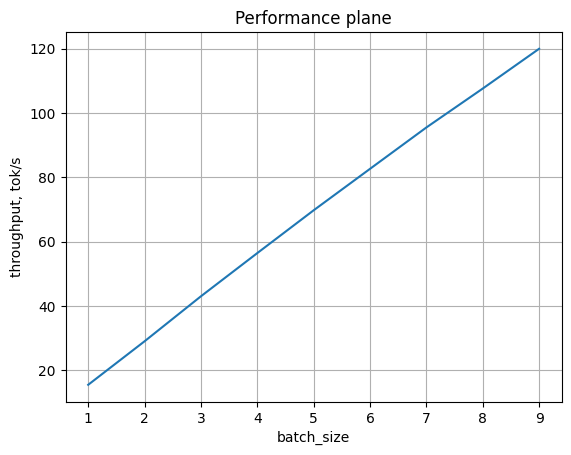

In [ ]:
# Draw a performance plane for different batch sizes
draw_plot(
    throughputs.keys(),
    throughputs.values(),
    title="Performance plane",
    xlabel="batch_size",
    ylabel="throughput, tok/s",
)

Take a look at performance plane from the lecture and compare with our results:

<img src="https://drive.google.com/uc?export=view&id=1390tWsmxVDb0c7FGpmrD4D9TlCA78SfF" alt="Performance plane" width="800"/>

We are definitely in Memory bound regime!

We can also draw a throughput-latency plane. This can help determine the regime in which we work and is also useful for comparing different hardware or code optimizations.

<img src="https://drive.google.com/uc?export=view&id=1R0tfFXDxcuTgtbcZ_Elpt-HIhjyJyLC2" alt="Performance plane" width="500"/>


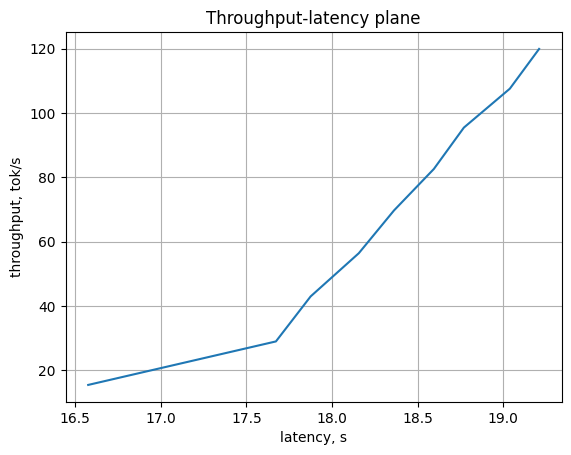

In [ ]:
# Draw a small throughput-latency plane of the llama 3.1 8B
draw_plot(
    latency_times.values(),
    throughputs.values(),
    title="Throughput-latency plane",
    xlabel="latency, s",
    ylabel="throughput, tok/s"
)

In this small scale, this plot doesn't look great. We can understand very little from them. We definitely need many more points on the plane. But how many? Let's calculate!

As we found in the lecture, optimal batch size can be roughly estimated by the formula:

$$\frac{\text{GPU_peak_FLOPS} * \text{bytes_per_parameter} }{2 * \text{GPU_memory_bandwidth}}$$

So, it will be:

- For L4:

  $$\frac{242\ \text{TFLOPs} * 2\ \text{byte} }{2 * 0.3\ \text{TB/s}} = 806$$

  (Which is an insane number; as you'll see, the LLM doesn't accommodate even close to that size.)

- For A100:

  $$\frac{312\ \text{TFLOPs} * 2\ \text{byte} }{2 * 2.0\ \text{TB/s}} = 156$$

- For H100:

  $$\frac{989.4\ \text{TFLOPs} * 2\ \text{byte} }{2 * 3.35\ \text{TB/s}} = 295$$

Based on the calculations, we need to draw a plane with at least 300 data points. Therefore, our batch size should be greater than 300 to see how the LLM works in a compute-bound regime. Let's calculate latency and throughput for batch sizes up to 320.

**You might want to skip this computation and just look at the plots, because it's quite lengthy**

## Plotting the performance plane for the Colab's L4 GPU.

In this demonstration, we also included safe cycle termination when GPU runs out of memory, so we can see which batch sizes can actually fit the GPU.

In [ ]:
# Calculate throughput and latency for batch sizes up to 320
max_batch_size = 320
expanded_texts = texts * (max_batch_size // len(texts))
latency_times = {}
throughputs = {}

for bs in tqdm.tqdm(range(1, max_batch_size)):
    try:
        latency_times[bs] = generate_with_batch_size(expanded_texts[:bs], batch_size=bs)[1]
        throughputs[bs] = 256 / latency_times[bs] * bs
    except RuntimeError as e:
        torch.cuda.empty_cache()
        print(e)
        break


 44%|████▍     | 141/319 [1:31:36<1:55:38, 38.98s/it]

CUDA out of memory. Tried to allocate 294.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 253.38 MiB is free. Process 21065 has 21.91 GiB memory in use. Of the allocated memory 20.03 GiB is allocated by PyTorch, and 1.65 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


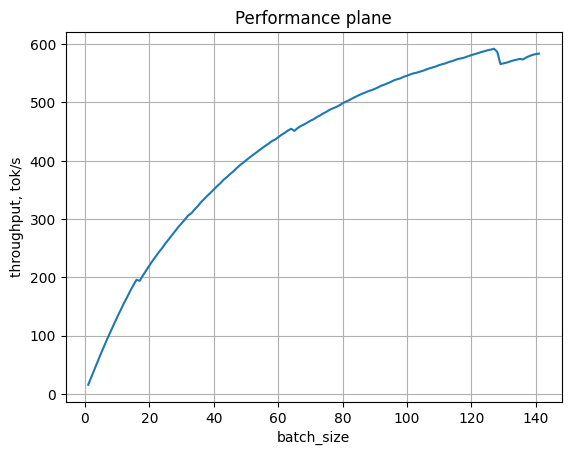

In [ ]:
# Draw a performance plane for batch sizes up to max_batch_size
draw_plot(
    throughputs.keys(),
    throughputs.values(),
    title="Performance plane",
    xlabel="batch_size",
    ylabel="throughput, tok/s"
)

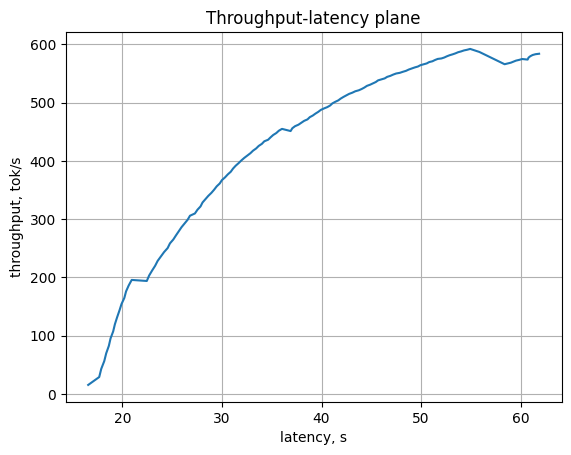

In [ ]:
# Draw a small throughput-latency plane of the llama 3.1 8B
draw_plot(
    latency_times.values(),
    throughputs.values(),
    title="Throughput-latency plane",
    xlabel="latency, s",
    ylabel="throughput, tok/s"
)

## Plotting the performance plane for the A100 GPU.

Since you'll be changing a kernel between the demostrations, we've included all the necessary code here, so you don't need to run all the above cells again:

In [ ]:
from huggingface_hub import snapshot_download
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import os
import datetime
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import functools
import time
import transformers
import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "false"
MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B-Instruct"
CACHE_DIR = "/ml_ops_course/llama3_instruct"
with open("hf_access_token", "r") as file:
    hf_access_token = file.read().strip()

snapshot_download(
    repo_id=MODEL_NAME,
    cache_dir=CACHE_DIR,
    max_workers=15,
    token=hf_access_token,
    )

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    use_fast=False,
    token=hf_access_token,
    )

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    cache_dir=CACHE_DIR,
    local_files_only=True,
)

pipeline = transformers.pipeline(
    "text-generation",
    model=MODEL_NAME,
    tokenizer=transformers.AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False),
    model_kwargs={
        "torch_dtype": torch.bfloat16,
        "cache_dir": CACHE_DIR,
    },
    device_map="auto",
    token=hf_access_token,
)

pipeline.tokenizer.pad_token_id = pipeline.tokenizer.eos_token_id
pipeline.model.generation_config.pad_token_id = pipeline.tokenizer.pad_token_id
pipeline.tokenizer.padding_side = 'left'

generation_params = {
    "do_sample": True,
    "temperature": 0.6,
    "top_p": 0.9,
}

NUM_TOKENS_TO_GENERATE = 256

texts = [
    "I love this!",
    "How dare you!",
    "Robots are greate!",
    "Not happy with the product.",
    "I'm very alone.",
    "Coding is cool!",
    "My wife so beautiful.",
    "There's a typo in the third string.",
    "Take me out!",
    "Wonderwall,",
]

generate = functools.partial(
    pipeline,
    max_new_tokens=NUM_TOKENS_TO_GENERATE,
    eos_token_id=None,
    **generation_params,
)

def generate_with_batch_size(
    inputs: str | list[str],
    batch_size: int = 1,
) -> tuple[list[dict[str: str]], int]:
    start = time.time()
    res = generate(
        inputs,
        batch_size=batch_size,
    )
    res_time = time.time() - start
    return res, res_time

def draw_plot(
    xdata: list[float],
    ydata: list[float],
    title: str | None = None,
    xlabel: str | None = None,
    ylabel: str | None = None,
):
    plt.plot(xdata, ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()


Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

LICENSE:   0%|          | 0.00/7.63k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/44.0k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

USE_POLICY.md:   0%|          | 0.00/4.69k [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

params.json:   0%|          | 0.00/199 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

original/consolidated.00.pth:   0%|          | 0.00/16.1G [00:00<?, ?B/s]

original/tokenizer.model:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Max lenghth for the inputs to a model: 131072 tokens


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [ ]:
# Calculate throughput and latency for batch sizes up to 320
max_batch_size = 320
expanded_texts = texts * (max_batch_size // len(texts))
latency_times = {}
throughputs = {}

for bs in tqdm.tqdm(range(1, max_batch_size)):
    try:
        latency_times[bs] = generate_with_batch_size(expanded_texts[:bs], batch_size=bs)[1]
        throughputs[bs] = 256 / latency_times[bs] * bs
    except RuntimeError as e:
        torch.cuda.empty_cache()
        print(e)
        break


 59%|█████▉    | 189/319 [50:19<34:36, 15.98s/it]

CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 58.88 MiB is free. Process 35481 has 39.49 GiB memory in use. Of the allocated memory 36.68 GiB is allocated by PyTorch, and 2.31 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


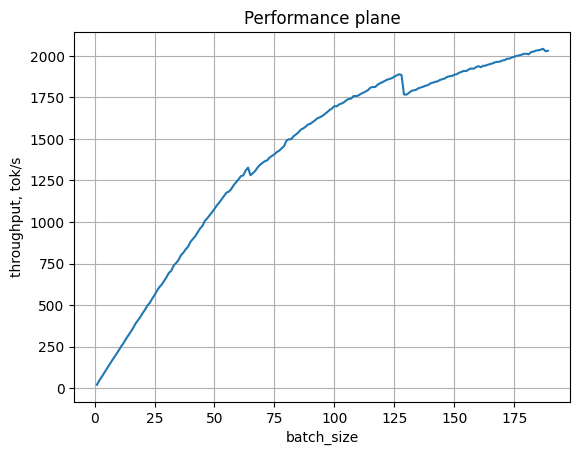

In [ ]:
# Draw a performance plane for batch sizes up to max_batch_size
draw_plot(
    throughputs.keys(),
    throughputs.values(),
    title="Performance plane",
    xlabel="batch_size",
    ylabel="throughput, tok/s"
)

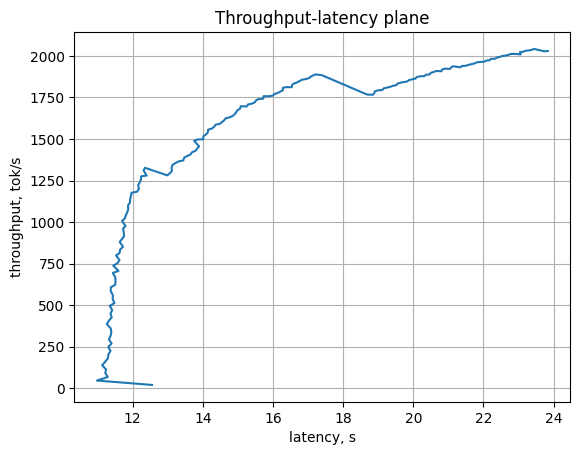

In [ ]:
# Draw a small throughput-latency plane of the llama 3.1 8B
draw_plot(
    latency_times.values(),
    throughputs.values(),
    title="Throughput-latency plane",
    xlabel="latency, s",
    ylabel="throughput, tok/s"
)

## Plots for H100

Colab doesn't have H100 GPUs, but we've run experiments for you:

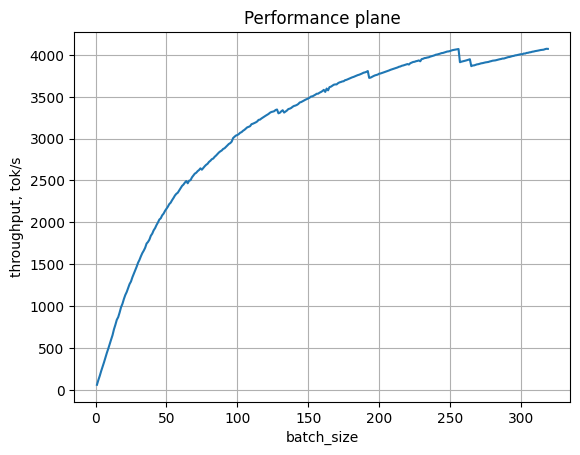

In [ ]:
# Draw a performance plane for batch sizes up to max_batch_size
draw_plot(
    throughputs.keys(),
    throughputs.values(),
    title="Performance plane",
    xlabel="batch_size",
    ylabel="throughput, tok/s"
)

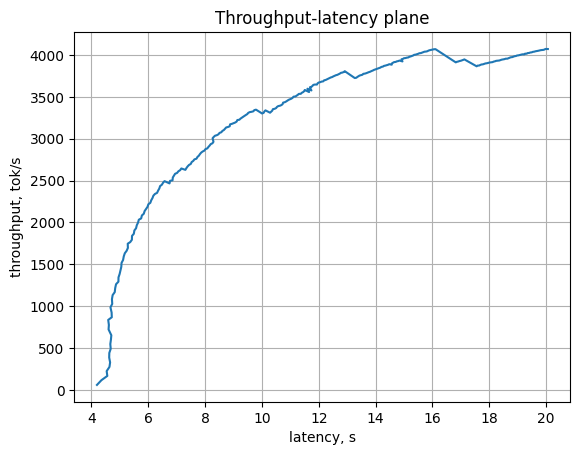

In [ ]:
# Draw a small throughput-latency plane of the llama 3.1 8B
draw_plot(
    latency_times.values(),
    throughputs.values(),
    title="Throughput-latency plane",
    xlabel="latency, s",
    ylabel="throughput, tok/s"
)

In these planes, we can see how our model starts to perform in the `compute-bound regime`: throughput stays nearly constant while latency increases.

These curves are a bit different from the theoretical ones, but we can still easily find patterns. As we mentioned in the lecture, the difference can be explained by the simplicity of our FLOPs and memory movement models. We do not account for the memory required for caching and the FLOPs needed for the attention mechanism. However, we will discuss that a bit later to understand how to make our computational model closer to reality.

# Practice part

**This part is by [Stanislav Fedotov](https://www.linkedin.com/in/stanislav-fedotov-1651b0243/)**

If you encounter any difficulties or simply want to see our solutions, feel free to check the [Solutions notebook](https://colab.research.google.com/github/Nebius-Academy/LLM-Engineering-Essentials/blob/main/topic4/4.3_llm_inference_metrics.ipynb).

## Task 1. GPU and long contexts

So far, we mainly discussed how LLM inference behaves as the batch size increases. However, there is another dimension to it - sequence length. Elaborate prompts, rich context, and, of course, non-linear reasoning contribute to large sequence lengths. And you'd want to know which context size fits your GPU and how latency changes with it!

In this task, we encourage you to experiment with [**Llama-3.1-8B-Instruct**](https://huggingface.co/meta-llama/Llama-3.1-8B). Run inference with

* prompt lengths starting from, say, 512 with step 1024 (if you're generous), 2048, or 4095 (if you're low on time or Colab compute units).
* several values of `max_new_tokens` (completion length), say, 128, 256, and 512.

Make sure that your model *really* produces `max_new_tokens` tokens and not less, otherwise your results will be skewed. You can achieve this by passing `eos_token_id=None` in the generation parameters.

Check at which prompt size the generator pipeline will crash with the out-of-memory error. How closely will you be able to approach the theoretical sequence length 200k? Measure latency and memory consumption and plot curves *prompt length vs latency* and *prompt length vs memory consumption* for each value of `max_new_tokens`. Compare these curves.

**Note**. It would seem more logical to plot *(prompt length + completion length) vs latency* and *(prompt length + completion length) vs memory consumption*, and we recommend you to try it as well. But looking at *prompt length vs ...* might prove instructive.

Also, make theoretical computations and compare them with your empyrical evidence. Ponder on the nature of their differences.

**Note**. For this task, you'll need a way of getting prompts with prescribed length. Here is a couple of ideas where to get them:

* Clone a relatively large code library (`transformers`, for example) and concatenate files until you get the needed prompt size. Then add `"What is the purpose and functionality of this code?"` or something like that. Just don't forget that this question also contributes to the prompt length.
* Pick a long enough book, take its beginning and ask `"Describe the plot and the characters of the above fragment"`

**Note**. We suggest not using `apply_chat_template` and just passing the raw prompts into `pipeline(prompt, return_full_text=False,**generation_params)`. This will make easier for you to control the actual prompt length.

**Note**. If you want your experiments to run faster, use a smaller model, say, **Qwen2.5-3B-Instruct**.

In [ ]:
# <YOUR SOLUTION HERE>

## Task 2. Directly measuring the KV-cache size

In Task 1, we relied on quantifying total memory allocation and theoretical KV-cache size. Now, let's see if the actual size of KV-cache matches our theoretical predictions.

For that, you'll need to use Pytorch hooks. However, the transformer may be reluctant to show you the kv-cache, and some additional work might be needed.

**Disclaimer**. The particular code might vary between models and attention implementations, so be extra careful if you try using the advice below. It should work for **Llama-3.1-8B** though.

**Advice**. To get KV-cache, you'll need to allow your hook to receive `kwargs` argument in addition to the usual `module, input, output`. For that, register your hook as follows:

```python
layer.self_attn.register_forward_hook(your_hook, with_kwargs=True)
```

Now, `your hook` will have interface

```python
your_hook(module, input, kwargs, output)
```

and the cache for the `layer_idx`-th layer will be in

```python
cache = kwargs.get("past_key_value")
k, v = cache[layer_idx]
```

Now, you can calculate the size of the key-cache in GB as

```python
k.numel()  * k.element_size() / 2**20
```

The hook will be called every time transformer is inferenced - that is, once during prompt processing and each time a new token is generated. Of course, you need the *maximal* kv-cache size. Though it can be interesting to check if the kv-cache size changes during generation (it shouldn't).

When you finish with the hook, run the benchmark for relatively small `prompt_length` values (like, $\leqslant$ 1024) and relatively large `max_new_tokens` - like from `prompt_length` to `2*prompt_length`. Plot how kv-cache size changes with `prompt_length` or `(prompt_length + completion_length)` and check if it aligns with theoretical estimates.

In [ ]:
# <YOUR SOLUTION HERE>

## Task 3. FlashAttention2

In this task, you'll try using **FlashAttention2**, the all-so-fashionable implementation of attention, which is so cool that it's better to use it whenever you can.

The problem is though that it's capricious and tricky to make work. It only supports certain GPU families (A100, H100, and H200 are among them; L4 and L40s are not). Also, it requires quite specific combinations of libraries. Your best chance at it is using a good docker image.

Below, we describe how we managed to run it in colab on June 30, 2025. However, we can give you no guarantee that the same code will work on your local machine or in another cloud.

In [ ]:
!pip install torch=='2.4.1+cu121' torchvision=='0.19.1+cu121' torchaudio=='2.4.1+cu121' --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.0/799.0 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 121.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 98.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 128.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/19

In [ ]:
!pip install -v flash-attn==2.8.0.post2 --no-build-isolation

Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 65.8 MB/s eta 0:00:00
  Running command python setup.py egg_info
  /usr/local/lib/python3.11/dist-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!

          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************

  !!
    dist.fetch_build_eggs(dist.setup_requires)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 8.1 MB/s eta 0:00:00


  torch.__version__  = 2.4.1+cu121


  running egg_info
  creating /tmp/pip-pip-egg-info-mfk5gyqs/flash_attn.egg-info
  writing /tmp/pip-pip-egg-info-mfk5gyqs/flash_attn.egg-info/PKG-IN

In [ ]:
!pip install transformers==4.51.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 95.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4


If the next cell runs successfully, you've nailed it!
Otherwise, you're in trouble...

In [ ]:
import flash_attn

Now, this should load a model with FlashAttention2. Just check the output; it should show whether you were successful.

In [ ]:
import os
os.environ["TRANSFORMERS_NO_TP"] = "1"
import time
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
from huggingface_hub import snapshot_download
from pathlib import Path

# Read HF token
with open("hf_access_token", "r") as file:
    hf_access_token = file.read().strip()

from huggingface_hub import login
login(token=hf_access_token)

def create_pipeline(
    model_name: str = "meta-llama/Meta-Llama-3.1-8B-Instruct",
    cache_dir: str = "/inference_essentials/model/",
    use_flash_attention: bool = True):

    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        use_fast=False
    )

    # Downloading the model
    print(f"Downloading model {model_name}...")
    snapshot_download(
        repo_id=model_name,
        cache_dir=cache_dir,
        max_workers=15
    )

    # Prepare model loading arguments
    model_kwargs = {
        "torch_dtype": torch.bfloat16,
        "device_map": "auto",
        "cache_dir": cache_dir,
        "local_files_only": True,
        "token": hf_access_token,
    }

    # Add FlashAttention2 configuration if available
    if use_flash_attention:
        print("Loading model with FlashAttention2...")
        model_kwargs["attn_implementation"] = "flash_attention_2"
        # Some models may need this additional parameter, but generally it is deprecated
        # model_kwargs["use_flash_attention_2"] = True
    else:
        print("Loading model with standard attention...")

    # Load the model
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        **model_kwargs
    )


    # Create pipeline with appropriate configuration
    pipeline_kwargs = {
        "task": "text-generation",
        "model": model,
        "tokenizer": tokenizer,
        "model_kwargs": {
            "torch_dtype": torch.bfloat16,
            "cache_dir": cache_dir,
        },
        "device_map": "auto",
        "token": hf_access_token,
    }

    pipeline = transformers.pipeline(**pipeline_kwargs)

    # Configure tokenizer settings
    pipeline.tokenizer.pad_token_id = pipeline.tokenizer.eos_token_id
    pipeline.model.generation_config.pad_token_id = pipeline.tokenizer.pad_token_id
    pipeline.tokenizer.padding_side = 'left'

    # Check if FlashAttention2 is actually being used
    if hasattr(model.config, 'attn_implementation'):
        print(f"Attention implementation: {model.config.attn_implementation}")
    elif hasattr(model.config, '_attn_implementation'):
        print(f"Attention implementation: {model.config._attn_implementation}")

    return tokenizer, model, pipeline

In [ ]:
tokenizer, model, pipeline = create_pipeline(model_name="Qwen/Qwen2.5-7B-Instruct",
                                             use_flash_attention=True)

In [ ]:
# <YOUR SOLUTION HERE>